# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

#print train_data[:5]


training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [22]:
def P1(num_examples=5):
    
    for i in range(0,num_examples):
        print "Label is:", newsgroups_train.target_names[train_labels[i]]
        print train_data[i]
        print "------------------------------------------------"

P1()

Label is: comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------------------------------------------------
Label is: talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstra

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [81]:
def P2():
    vector = CountVectorizer()
    output = vector.fit_transform(train_data)
    print "Part a. Size of the vocabulary: ", output.shape[1]
    print "\tAverage number of non-zero features per example: ", output.nnz/output.shape[0]
    print "\tFraction of non-zero entries in the matrix: ", 100*float(output.nnz/float(output.shape[0]*output.shape[1])), "%"
    
    feature_string = vector.get_feature_names()
    print "Part b. The 0th feature string is:", feature_string[0]
    print "\tThe last feature string is", feature_string[-1]
    
    new_vector = CountVectorizer()
    new_vector.vocabulary = ["atheism", "graphics", "space", "religion"]
    new_output = new_vector.fit_transform(train_data)
    print "Part c. Size of the vocabulary: ", new_output.shape[1]
    print "\tAverage number of non-zero features per example: ", new_output.nnz/float(new_output.shape[0])

    bitrigram_vectorizer = CountVectorizer(analyzer='char' ,ngram_range=(2, 3))
    bitrigram_output = bitrigram_vectorizer.fit_transform(train_data)
    print "Part d. Size of the vocabulary: ", bitrigram_output.shape[1]
    
    high_frequency_vector = CountVectorizer(min_df=10)
    high_frequency_output = high_frequency_vector.fit_transform(train_data)
    print "Part e. Size of the vocabulary: ", high_frequency_output.shape[1]
    
    train_dev_output = vector.fit_transform(train_data+dev_data)
    dev_output = vector.fit_transform(dev_data)
    train_output = vector.fit_transform(train_data)
    print "Part f. Size of the total (train + dev) vocabulary: ", train_dev_output.shape[1]
    print "\tSize of the dev vocabulary: ", dev_output.shape[1]
    print "\tSize of the train vocabulary: ", train_output.shape[1]
    #words in dev set missing in train set = words in both - words in train set 
    words_missing = train_dev_output.shape[1] - train_output.shape[1]
    print "\tFraction of the words in the dev data are missing from the vocabulary: ", words_missing/float(dev_output.shape[1])
P2()

Part a. Size of the vocabulary:  26879
	Average number of non-zero features per example:  96
	Fraction of non-zero entries in the matrix:  0.359782722696 %
Part b. The 0th feature string is: 00
	The last feature string is zyxel
Part c. Size of the vocabulary:  4
	Average number of non-zero features per example:  0.268436578171
Part d. Size of the vocabulary:  35478
Part e. Size of the vocabulary:  3064
Part f. Size of the total (train + dev) vocabulary:  30906
	Size of the dev vocabulary:  16246
	Size of the train vocabulary:  26879
	Fraction of the words in the dev data are missing from the vocabulary:  0.247876400345


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [121]:
def P3():
    
    #K NEAREST NEIGHBORS CLASSIIFER
    vector = CountVectorizer()
    output_data = vector.fit_transform(train_data)

    # Taking the square root of the training data sample size, k should be from 1-164
    k_values = {'n_neighbors': range(1,164)}
    # Create a k-Nearest-Neighbors model
    kNN_model = KNeighborsClassifier()    
    grid_search = GridSearchCV(kNN_model, k_values)
    grid_search.fit(output_data, train_labels)
    print 'Best KNN score:', grid_search.best_score_, 'with k= ', grid_search.best_params_
    
    kNN_151_model = KNeighborsClassifier(n_neighbors=151)    
    kNN_151_model.fit(output_data, train_labels)
    
    dev_output = vector.transform(dev_data)
    preds = kNN_151_model.predict(dev_output)
    f1_score = metrics.f1_score(dev_labels, preds, average='macro')
    print "F1 score for Nearest Neighbor Classifier: ", f1_score
    
    #MULTINOMIAL NAIVE BAYES
    alphas = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
    multinomial = MultinomialNB()
    grid_search = GridSearchCV(multinomial, alphas)
    grid_search.fit(output_data, train_labels)
    print '\nBest Multinomial NB score:', grid_search.best_score_, 'with k= ', grid_search.best_params_
    
    multinomial_model = MultinomialNB(alpha=0.005)
    multinomial_model.fit(output_data, train_labels)
    multinomial_preds = multinomial_model.predict(dev_output)
    multinomial_f1_score = metrics.f1_score(dev_labels, multinomial_preds, average='macro')
    print "F1 score for Multinomial Naive Bayes: ", multinomial_f1_score
    
    #LOGISTIC REGRESSION
    vector = CountVectorizer()
    output_data = vector.fit_transform(train_data)
    Cs = {'C': [.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 1]}
    logistic_regression = LogisticRegression(penalty='l2')
    grid_search = GridSearchCV(logistic_regression, Cs)
    grid_search.fit(output_data, train_labels)
    print '\nBest Logistic regression score:', grid_search.best_score_, 'with k= ', grid_search.best_params_
    
    logistic_model = LogisticRegression(penalty='l2', C=0.2)
    logistic_model.fit(output_data, train_labels)
    logistic_preds = logistic_model.predict(dev_output)
    logistic_f1_score = metrics.f1_score(dev_labels, logistic_preds, average='macro')
    print "F1 score for Logistic regression: ", logistic_f1_score
    
    for c in  [.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 1]:
        logistic_mod = LogisticRegression(penalty='l2', C=c)
        logistic_mod.fit(output_data, train_labels)
        sscoefs = [(logistic_mod.coef_[i]**2).sum() for i in range(4)]
        print "When C = ", c, sscoefs
P3()

Best KNN score: 0.450344149459 with k=  {'n_neighbors': 151}
F1 score for Nearest Neighbor Classifier:  0.402814934441

Best Multinomial NB score: 0.830875122911 with k=  {'alpha': 0.005}
F1 score for Multinomial Naive Bayes:  0.752940178237

Best Logistic regression score: 0.776302851524 with k=  {'C': 0.2}
F1 score for Logistic regression:  0.687784405014
When C =  0.05 [14.073341536756063, 13.669108200114181, 14.604085044538358, 11.860678735845315]
When C =  0.1 [27.129497327510379, 24.659044263841249, 27.457741536123102, 23.026053110103373]
When C =  0.15 [38.912999065733466, 34.184693638106616, 38.908775323097714, 33.227827371372541]
When C =  0.2 [49.743949463556305, 42.743375142092852, 49.328608616449102, 42.667023075237402]
When C =  0.25 [59.810210976546166, 50.569645895992494, 58.942512260058393, 51.462600735624861]
When C =  0.3 [69.269980491325811, 57.868652367245886, 67.89907403205811, 59.782845085852635]
When C =  0.35 [78.240821075254019, 64.693586060491768, 76.321223966

ANSWER:

a. Nearing neighbor classifiers don't work well when there are too many features. The feature representation here are sparse.

b. Logistic regression doesn't work as well as the multinomial NB here because logistic regression works better when the training data size is smaller relative to the feature size, which is not the case here. NB work well with less training data, as the estimates are based on the joint density function. 

c. C is the inverse of regularization strength, so higher the C, lower the regularization, therefore the sum increases

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [493]:
def P4():
    #LOGISTIC REGRESSION
    vector = CountVectorizer()

    output_data = vector.fit_transform(train_data)
    feature_string = vector.get_feature_names()

    logistic_model = LogisticRegression(penalty='l2', C = 0.2)
    logistic_model.fit(output_data, train_labels)
    coefs = logistic_model.coef_

    #find the top feature
    features_idx=[]
    for i in range(coefs.shape[0]):
        #argsort will return the indices that would sort an array, this give the indices of the 5 features with the largest weights
        features_idx.extend( np.argsort(-coefs[i])[:5] )
    top20_features = []
    
    #create 20 features
    for j in range(len(features_idx)):
        top20_features.append(feature_string[features_idx[j]])

    print "Unigram Features:"
    print "Features\t", newsgroups_train.target_names[0],'\t', newsgroups_train.target_names[1], '\t', newsgroups_train.target_names[2], '\t', newsgroups_train.target_names[3]
    print "==================================================================================="
    
    table=[]
    for k in range(len(top20_features)):
        table.append([top20_features[k], coefs[0][features_idx[k]], coefs[1][features_idx[k]], coefs[2][features_idx[k]], coefs[3][features_idx[k]]])
    
    for i in table:
        print "{:10}{: 18.3f}{: 18.3f}{: 18.3f}{: 18.3f}".format(*i)
    
    #repeat same thing but for bigram 
    print "\n\nBigram Features:"
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
    bigram_output = bigram_vectorizer.fit_transform(train_data)
    bigram_feature_string = bigram_vectorizer.get_feature_names()

    logistic_model = LogisticRegression(penalty='l2', C = 0.2)
    logistic_model.fit(bigram_output, train_labels)
    bigram_coefs = logistic_model.coef_

    #find the top feature
    features_idx=[]
    for i in range(bigram_coefs.shape[0]):
        #argsort will return the indices that would sort an array, this give the indices of the 5 features with the largest weights
        features_idx.extend( np.argsort(-bigram_coefs[i])[:5] )
    top20_features = []
    
    #create 20 features
    for j in range(len(features_idx)):
        top20_features.append(bigram_feature_string[features_idx[j]])

    print "Features\t", newsgroups_train.target_names[0],'\t', newsgroups_train.target_names[1], '\t', newsgroups_train.target_names[2], '\t', newsgroups_train.target_names[3]
    print "==================================================================================="
    
    table=[]
    for k in range(len(top20_features)):
        table.append([top20_features[k], bigram_coefs[0][features_idx[k]], bigram_coefs[1][features_idx[k]], bigram_coefs[2][features_idx[k]], bigram_coefs[3][features_idx[k]]])
    
    for i in table:
        print "{:10}{: 18.3f}{: 18.3f}{: 18.3f}{: 18.3f}".format(*i)
    
P4()

Unigram Features:
Features	alt.atheism 	comp.graphics 	sci.space 	talk.religion.misc
bobby                  0.619            -0.151            -0.216            -0.293
atheism                0.616            -0.268            -0.266            -0.313
religion               0.615            -0.381            -0.500            -0.020
atheists               0.606            -0.087            -0.203            -0.421
islam                  0.528            -0.094            -0.213            -0.215
graphics              -0.503             1.255            -0.829            -0.471
image                 -0.342             0.833            -0.488            -0.280
file                  -0.214             0.809            -0.529            -0.373
3d                    -0.232             0.710            -0.414            -0.238
computer              -0.005             0.679            -0.427            -0.294
space                 -0.819            -0.875             1.506            -0.741
or

ANSWER: In the first table, we can see that the model does a pretty good job in assigning weight values to the words in the corresponding category. It has a clear diagonal positive and relatively large wieghts for the 5 features with their corresponding category. However, in the second table, the model gives positive weights to some features in the wrong categories. Also, note that "cheers kent" appear twice in the top 20 features list. Common words like "is not" and "the word" are positive in two categories.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [276]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #lowercasing everything
    s = s.lower()
    #removing sequences of numbers
    s = re.sub("\d+", "", s)
    #removing various other non-letter characters
    s = re.sub("[^A-Za-z0-9 \\n]", " ", s)
    return s

def P5():
    # Empty preprocessing
    empty_vect = CountVectorizer(preprocessor = empty_preprocessor)
    empty_data = empty_vect.fit_transform(train_data)
    empty_dev_data = empty_vect.transform(dev_data)
    empty_size = len(empty_vect.get_feature_names())
    
    empty_logistic = LogisticRegression(penalty='l2', C=0.2)
    empty_logistic.fit(empty_data, train_labels)            
    empty_pred = empty_logistic.predict(empty_dev_data)
    empty_f1 = metrics.f1_score(dev_labels, empty_pred, average='macro')
    
    # Better preprocessor
    #stop_word = ‘english’, a built-in stop word list for English is used.
    better_vect = CountVectorizer(preprocessor = better_preprocessor, stop_words = 'english')
    better_data = better_vect.fit_transform(train_data)
    better_dev_data = better_vect.transform(dev_data)
    better_size = len(better_vect.get_feature_names())
    
    better_logistic = LogisticRegression(penalty='l2', C=0.2)
    better_logistic.fit(better_data, train_labels)            
    better_pred = better_logistic.predict(better_dev_data)
    better_f1 = metrics.f1_score(dev_labels, better_pred, average='macro')

    print "The feature size reduced from", empty_size, "to", better_size, "and improve dev F1 by", 100*(better_f1-empty_f1), "point."
P5()

The feature size reduced from 33291 to 23750 and improve dev F1 by 3.03437815554 point.


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

L2 logistic Regression gives 107516 non-zero weights.

L1 C Value  # of non-zero weights  Accuracy of L2 Model
---------   ---------------------  --------------------
0.001 	    5 		   0.378698224852
0.005 	    22 		   0.442307692308
0.01 	    36 		   0.48224852071
0.05 	    208 		   0.655325443787
0.1 	    359 		   0.686390532544
0.15 	    510 		   0.708579881657
0.2 	    618 		   0.689349112426
0.25 	    772 		   0.680473372781
0.3 	    859 		   0.680473372781
0.35 	    984 		   0.681952662722
0.4 	    1115 		   0.671597633136
0.45 	    1118 		   0.673076923077
0.5 	    1244 		   0.66124260355
1 	    1816 		   0.683431952663
2 	    2571 		   0.692307692308
3 	    3095 		   0.687869822485
4 	    3622 		   0.687869822485
5 	    4029 		   0.702662721893
6 	    4726 		   0.707100591716
7 	    5155 		   0.708579881657
8 	    4473 		   0.698224852071
9 	    4830 		   0.695266272189
10 	    5002 		   0.702662721893
The number of non-zero learned weights with L1 logistic regression is a lot 

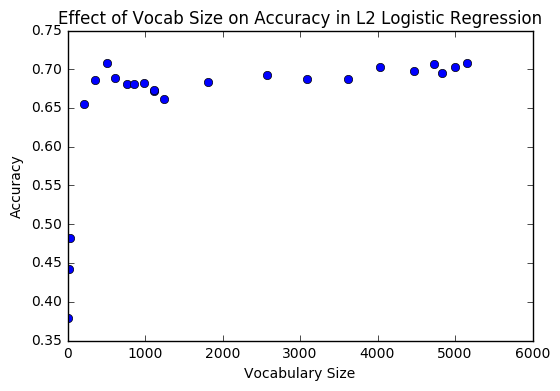

In [339]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    vect = CountVectorizer()
    output_data = vect.fit_transform(train_data)
    features = vect.get_feature_names()
    
    logistic_l2 = LogisticRegression(penalty='l2', tol=0.01)
    logistic_l2.fit(output_data, train_labels)            
    coefs_l2 = logistic_l2.coef_
    print "L2 logistic Regression gives", np.count_nonzero(coefs_l2), "non-zero weights.\n"
    print "L1 C Value  # of non-zero weights  Accuracy of L2 Model"
    print "---------   ---------------------  --------------------"
    accuracy_list=[]
    vocab_size=[]
    for c in  [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        logistic_l1 = LogisticRegression(penalty='l1', C=c, tol=0.01)
        logistic_l1.fit(output_data, train_labels)            
        coefs_l1 = logistic_l1.coef_       
        
        #Return the indices of the elements that are non-zero
        nonzero_idx = np.nonzero(coefs_l1)[1]
        new_vocab = []
        for i in np.unique(nonzero_idx):
            new_vocab.append(features[i])
        #reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight 
        vect_vocab = CountVectorizer(vocabulary = new_vocab)
        vect_vocab_train = vect_vocab.transform(train_data)
        vect_vocab_dev = vect_vocab.transform(dev_data)
        #retrain a model using "l2" with the reduced vocabulary
        logistic_l2.fit(vect_vocab_train, train_labels) 
        accuracy = logistic_l2.score(vect_vocab_dev, dev_labels)
        accuracy_list.append(accuracy)
        vocab_size.append(np.count_nonzero(coefs_l1))
        print c,'\t   ', np.count_nonzero(coefs_l1), '\t\t  ', accuracy

        
    print "The number of non-zero learned weights with L1 logistic regression is a lot smaller with that with L2."
    print "This is expected since L1 regularization drives lots of the weights to 0."
    
    plt.plot(vocab_size, accuracy_list, 'o')
    plt.title('Effect of Vocab Size on Accuracy in L2 Logistic Regression')  
    plt.ylabel('Accuracy') 
    plt.xlabel('Vocabulary Size') 
    plt.show()
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [497]:
def P7():
    vect = TfidfVectorizer()
    output_train_data = vect.fit_transform(train_data)
    output_dev_data = vect.transform(dev_data)
    features = vect.get_feature_names()
    
    logistic = LogisticRegression(C=100)
    logistic.fit(output_train_data, train_labels) 
    pred_label = logistic.predict(output_dev_data)
    accuracy = logistic.score(output_dev_data, dev_labels)
    print "Accuracy for a logistic regression using TfidfVectorizer is", accuracy

    #Probability estimates
    pred_prob = logistic.predict_proba(output_dev_data)
    #find the maximum prob for each 
    max_pred_prob = pred_prob.max(axis=1)
    R=[]
    for i in range(len(dev_labels)):
        #maximum predicted probability / predicted probability of the correct label
        R.append(max_pred_prob[i]/pred_prob[i][dev_labels[i]])

    # Create the confusion matrix for the dev data
    confusion = confusion_matrix(dev_labels, pred_label)
    print "Confusion Matrix for", 'labels names:', newsgroups_train.target_names, "is:\n", confusion    
    
    #top 3 index of documents where the ratio R is largest   
    print "\nThe top 3 documents with the largest ratio R:\n"
    large_r_idx = np.argsort(R)[-3:]
    for j in range(len(large_r_idx)):
        print "Document #", large_r_idx[j]
        print "==================="
        print "- R =", R[large_r_idx[j]]
        print "- Predicted label is", newsgroups_train.target_names[pred_label[large_r_idx[j]]]
        print "- True label is", newsgroups_train.target_names[dev_labels[large_r_idx[j]]]
        print "\n", dev_data[large_r_idx[j]]
P7()

Accuracy for a logistic regression using TfidfVectorizer is 0.763313609467
Confusion Matrix for labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'] is:
[[102  11  19  33]
 [  5 168  10   2]
 [ 10  20 165   4]
 [ 31  10   5  81]]

The top 3 documents with the largest ratio R:

Document # 607
- R = 287.179564529
- Predicted label is talk.religion.misc
- True label is alt.atheism


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

Document # 665
- R = 325.004110289
- Predicted label is comp.graphics
- True label is talk.religion.misc

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
Document # 215
- R = 929.357806795
- Predicted label is comp.graphics
- True label is talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former tit

ANSWER: 

The TfidfVectorizer is different from the CountVectorizer in that it not only simply count the number of times an expression appear in the document, it also takes into account the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently. 

Two mistakes I see the model is making include classifying the document 'comp.graphics' when it has common computer-related terms such as "online" and "ftp", and, from the confusion matrix, misclassification between 'alt.atheism' and 'talk.religion.misc'. The misclassification is understandable since the two topics can be similar.

One way to fix the first mistake is to include those common computer-related terms (that are not graphic-specific) in the stop word parameter. For example, exclude the terms "online", "ftp", "email" or "internet" from all documents. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.